# W14 PyTorch와 CNN으로 이미지 분류하기
### CNN 기반 이미지 분류 모델(SimpleCNN, ResNet)을 활용하기

* Dataset: EMNIST (balanced)
> * 손으로 쓰여진 숫자와 알파벳으로 구성된 데이터셋
> * 각 이미지는 가로 28 pixel, 세로 28 pixel로 총 28 * 28 pixel로 구성
> * 112,800개의 학습 이미지와 18,800개의 테스트 이미지로 구성
> * 47개의 클래스


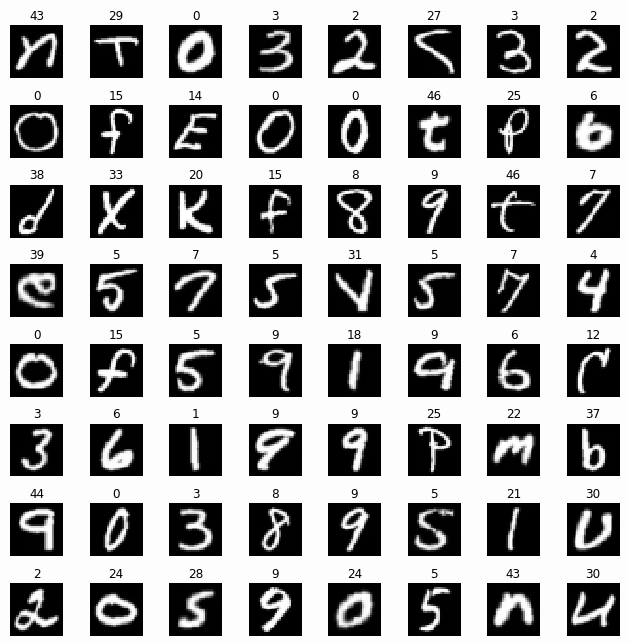

## Import

In [ ]:
# 필요한 라이브러리들 import
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import EMNIST

## EMNIST 데이터셋 로드 및 전처리

In [ ]:
# EMNIST 데이터셋 로드 및 전처리
# EMNIST 데이터셋 전처리 설정
transform = transforms.Compose([
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST 데이터셋의 평균 및 표준편차 변환
])

# EMNIST 데이터셋 다운로드
train_dataset = EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform)
test_dataset = EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform)


In [ ]:
# 모델 학습과 테스트를 위한 데이터 로더
batch_size = 64 # 배치사이즈는 64
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

# 데이터로더로 각 데이터의 형태 확인(총 수량, 채널 수, 높이, 너비)
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

## 간단한 CNN 모델 정의
### 사용한 것들
> * conv : convolution layer, 합성곱 연산을 수행
> * fc : fully connected layer, input으로 받은 정보를 평탄화
> * relu : 활성화 함수
> * max_pool2d: pooling 연산으로 주요 정보는 유지하고 피쳐맵 크기 축소
> * view: 텐서의 모양변경

### 합성곱 연산
* 출처: https://wikidocs.net/62306

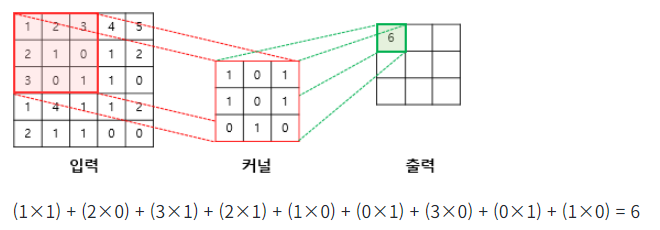

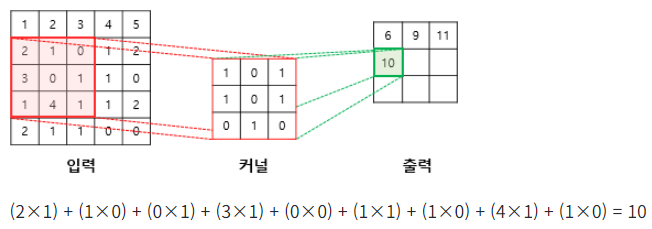

### 패딩
* 합성곱 연산과정에서 피쳐맵의 크기가 줄어드는것을 줄이고 외곽쪽에 있는 정보의 손실을 줄이기 위해 사용

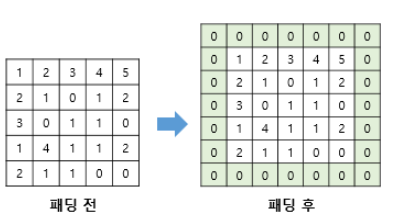

### 풀링 연산
* 주로 평균 average pooling, 최대값 max pooling이 활용됨

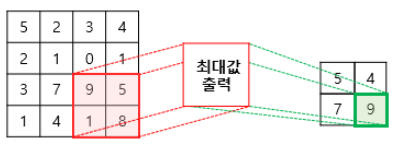

In [ ]:
# 간단한 CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 47)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 32 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## 학습과 테스트를 위한 함수 정의

In [ ]:
# 모델 학습
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) # dataloader에서 feature정보인 X와 대응되는 정답값 y를 연산을 수행할 장치에 할당

        # 예측 오류 계산
        pred = model(X) # X에 할당된 데이터에 대해 예측
        loss = loss_fn(pred, y) # 손실함수로 실제값 y와 예측값간 오차 계산

        # 역전파
        optimizer.zero_grad() # 기울기 초기화
        loss.backward() # 역전파
        optimizer.step() # 가중치 업데이트

        # (option) 현재 학습상태 출력
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
# 모델 테스트
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # 데이터 수 확인
    num_batches = len(dataloader) # 배치사이즈 확인

    # 학습이 아니라 평가 목적이므로 해당 모드로 변경
    model.eval()

    # 오차와 정답 수를 0으로 초기화, 지정
    test_loss, correct = 0, 0

    # 평가 (평가과정은 학습때처럼 기울기 계산 필요가 없으므로 no_grad()활용)
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item() # 오차 합산
            correct += (pred.argmax(1) == y).type(torch.float).sum().item() # 맞춘 수 합산
    test_loss /= num_batches # test_loss에 저장된 오차를 배치수만큼 나누어 다시 test_loss에 저장
    correct /= size # correct에 저장된 수를 데이터 수만큼 나누어 다시 correct에 저장
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

## 학습

In [ ]:
# CPU 혹은 GPU로 연산을 수행할 장치(device) 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")


In [ ]:
# 모델 객체 생성
model = SimpleCNN().to(device) #앞에서 정의한 SimpleCNN 모델 생성

# 손실 함수와 옵티마이저 설정
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# epoch 설정
epochs = 1

# epoch수 만큼 학습을 위한 loop및 학습중 성능 확인을 위한 코드
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer) # 학습을 위해 만든 train 함수 사용
    test(test_dataloader, model, loss_fn) # 모델의 테스트를 위해 만든 test 함수 사용
print("Done!")

## 테스트 및 결과 시각화

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

classes = [str(i) for i in range(47)]

#이미지 결과 시각화를 위한 함수 정의
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    np_image = img.numpy()
    np_image = np.transpose(np_image, (1, 2, 0))

    plt.imshow(np_image, cmap=plt.cm.binary)
    if predictions_array == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{classes[int(predictions_array)]}({classes[int(true_label)]})",
               color=color)

model.eval()

size = len(test_dataloader.dataset) # 데이터 수 확인
num_batches = len(test_dataloader)

test_loss, correct = 0, 0

# 테스트 데이터에 대한 예측 수행
predictions = []
X_test = []
y_test = []
with torch.no_grad():
    for images, label in test_dataloader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # 각 이미지에 대한 예측된 클래스 얻기
        correct += (predicted.cpu() == label).type(torch.float).sum().item() # 맞춘 수 합산
        predictions.extend(predicted.cpu().numpy())
        X_test.extend(images.cpu())
        y_test.extend(label)

    correct /= size # correct에 저장된 수를 데이터 수만큼 나누어 다시 correct에 저장

print(f"Accuracy: {(100*correct):>0.1f}% ")

In [ ]:
# 맞춘것은 파란색, 틀린 예측은 빨간색으로 표시하여 시각화
num_rows = 3
num_cols = 10
num_images = num_rows * num_cols

plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(1,num_images+1):
    plt.subplot(num_rows, 2 * num_cols, i)
    plot_image(i, predictions[i], y_test, X_test)


plt.tight_layout()
plt.show()


# ResNet 활용

### ResNet18의 모델 구조
- 출처: https://debuggercafe.com/implementing-resnet18-in-pytorch-from-scratch/
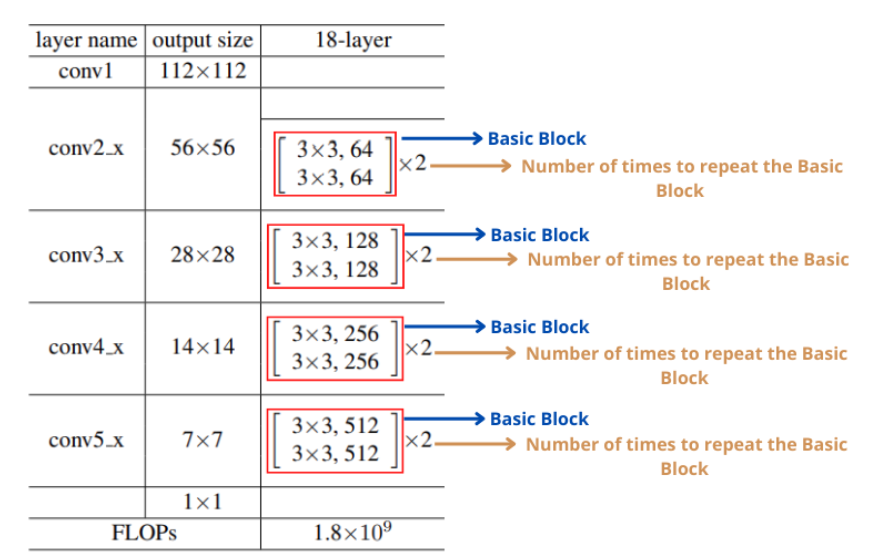

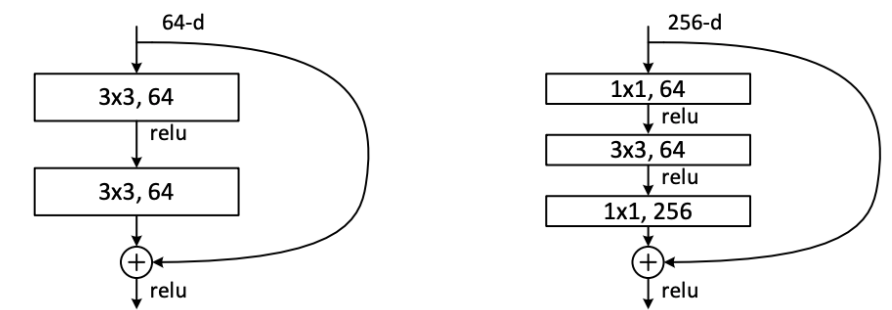

In [ ]:
from torchvision.models import resnet18

# EMNIST 데이터셋 로드 및 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet은 일반적으로 224x224 크기의 입력을 기대합니다.
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST 데이터셋의 평균 및 표준편차
])

train_dataset = EMNIST(root='./data',  split='balanced',train=True, download=False, transform=transform)
test_dataset = EMNIST(root='./data',  split='balanced',train=False, download=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# ResNet 모델 불러오기
model = resnet18(pretrained=False,num_classes=47)  # 미리 학습된 가중치를 사용하지 않음
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) # 원래는 RGB입력을 받지만 EMNIST는 1차원 흑백이므로 처리 필요

# 모델 정보를 연산장치로 옮기기
model = model.to(device)

# 모델 구조 확인
print(model)

In [ ]:
# 손실 함수와 옵티마이저 설정
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# epoch 설정
epochs = 1

# epoch수 만큼 학습을 위한 loop및 학습중 성능 확인을 위한 코드
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer) # 학습을 위해 만든 train 함수 사용
    test(test_dataloader, model, loss_fn) # 모델의 테스트를 위해 만든 test 함수 사용
print("Done!")

In [ ]:
model.eval()

size = len(test_dataloader.dataset) # 데이터 수 확인
num_batches = len(test_dataloader)

test_loss, correct = 0, 0

# 테스트 데이터에 대한 예측 수행
predictions = []
X_test = []
y_test = []
with torch.no_grad():
    for images, label in test_dataloader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # 각 이미지에 대한 예측된 클래스 얻기
        correct += (predicted.cpu() == label).type(torch.float).sum().item() # 맞춘 수 합산
        predictions.extend(predicted.cpu().numpy())
        X_test.extend(images.cpu())
        y_test.extend(label)

    correct /= size # correct에 저장된 수를 데이터 수만큼 나누어 다시 correct에 저장

print(f"Accuracy: {(100*correct):>0.1f}% ")

In [ ]:
# 분류 결과 확인
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions, digits=3))


### (Option) Lniear 모델 채우기

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import EMNIST
from torch.utils.data import DataLoader

# 데이터셋 로드 및 전처리
transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Normalize((0.5,), (0.5,))  # 이미지를 정규화
])

train_dataset = EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform)
test_dataset = EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Fully Connected Neural Network 모델 정의
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc_layers = nn.Sequential(
            nn.Linear(1*28*28, 512), # EMNIST 이미지데이터를 처리하기 위해서는 이미지 한장당 몇차원의 input을 받아야 할까?
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 47 )  # EMNIST는 몇개의 결과를 출력해야 할까?
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x

# 모델 초기화
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleMLP().to(device)

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

# 모델 평가
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy}")